# Test using the Alpha Vantage Quote <a name="top"></a>
## Table of Contents
[Setup](#setup)<br>
[Intraday Data](#intraday)<br>
[Daily and Longer Data](#daily)<br>
[Spread](#spread)<br>

## Setup<a name="setup"></a>
 [top](#top)<br>
 Preliminary set-up as well for both csv and json download

In [1]:
import datetime as dt
import os
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import mkt_util as mu
%matplotlib inline

The parameter data for qutoes.
* DJIA: .DJI
* SPX: .SPX
* Apple: AAPL
* Marks & Spencer: MKS.L
* Canadian Tire: CTC-A.TO

In [2]:
ticker = 'AAPL'
intraday = mu.get_intraday_prices(ticker)
time.sleep(12)
daily = mu.get_daily_prices(ticker)
aapl = mu.Security('AAPL', intraday, daily)

## Intraday Data<a name="intraday"></a>
 [top](#top)<br>
 In this section we'll first read in the csv. After the csv we also have the code for reading in json, but unfortunately pivotting the df is currently working.

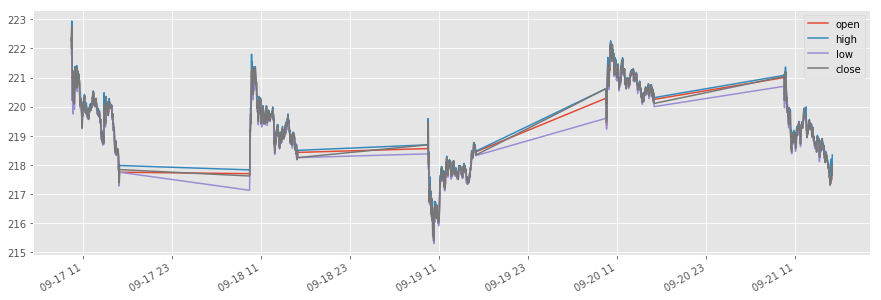

In [3]:
aapl.get_intraday().drop(columns=['volume']).plot(figsize=(15, 5));

## Daily and Longer Data <a name="daily"></a>
[top](#top)<br>

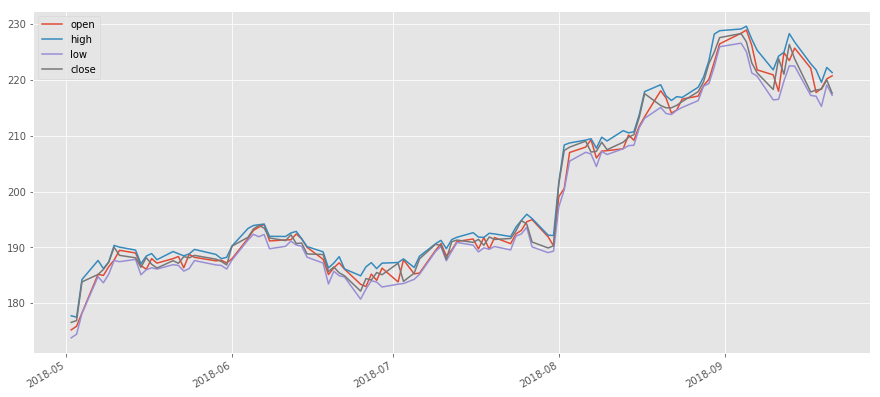

In [4]:
aapl.get_daily()[['open', 'high', 'low', 'close']].plot(figsize=(15, 7));

## Spread <a name="spread"></a>
[top](#top)<br>

In this section we're comparing the prices two of Canada's largest publicly traded life insurance compnies. The default time series length is 100 datapoints. For the study we want to two years plus a month of history. The extra month at the beginning allows us to have 20-day rolling histories 

In [5]:
ticker = 'MFC.TO'
daily = mu.get_daily_prices(ticker, output='full')
mfc_to = mu.Security('MFC.TO', intraday, daily)

ticker = 'SLF.TO'
daily = mu.get_daily_prices(ticker, output='full')
slf_to = mu.Security('SLF.TO', intraday, daily)

Add rolling statistics for average, median and std as well as daily log return which we can use to calculate profitability. And plot prices and spreads. 

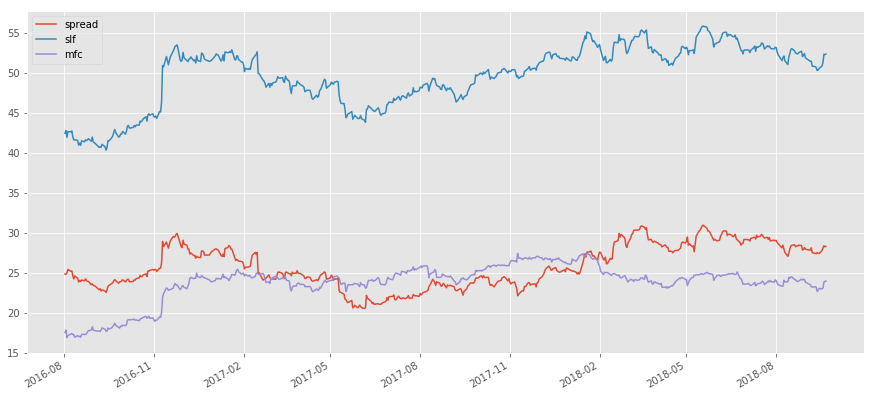

In [14]:
df = pd.DataFrame({'slf': slf_to.get_daily()['close'],
                   'mfc': mfc_to.get_daily()['close']})
df['spread'] = df['slf'] - df['mfc']
df['20-day avg'] = df['spread'].rolling(20).mean()
df['20-day median'] = df['spread'].rolling(20).median()
df['20-day std'] = df['spread'].rolling(20).std()
df['20-day up'] = df['20-day avg'] + df['20-day std']
df['20-day dn'] = df['20-day avg'] - df['20-day std']
df = df['2016-07-31':]
df['ret'] = np.log(df['spread']) - np.log(df['spread'].shift(1))
df[['spread', 'slf', 'mfc']].plot(figsize=(15, 7));

The chart above shows us the price of each stock as well as the spread. When the spread is low, we want to buy SLF and short MFC and when it is high we want to do the reverse and short SLF and buy MFC. We want to figure out when is the spread high and when is it low.

Plot the spread relative to its two year average.

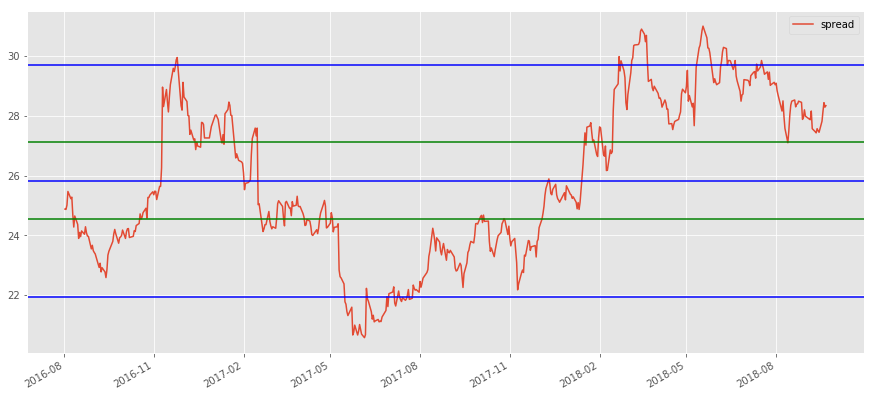

In [15]:
df[['spread']].plot(figsize=(15, 7))
plt.axhline(y=df['spread'].mean(), color='b')
plt.axhline(y=df['spread'].mean()*1.15, color='b')
plt.axhline(y=df['spread'].mean()*1.05, color='g')
plt.axhline(y=df['spread'].mean()*0.95, color='g')
plt.axhline(y=df['spread'].mean()*0.85, color='b');

In [16]:
df = mu.calc_fix_sprd_trade(df)

Short above: 29.70; Cover at 26.09
Long below: 21.96; Cover at 25.57


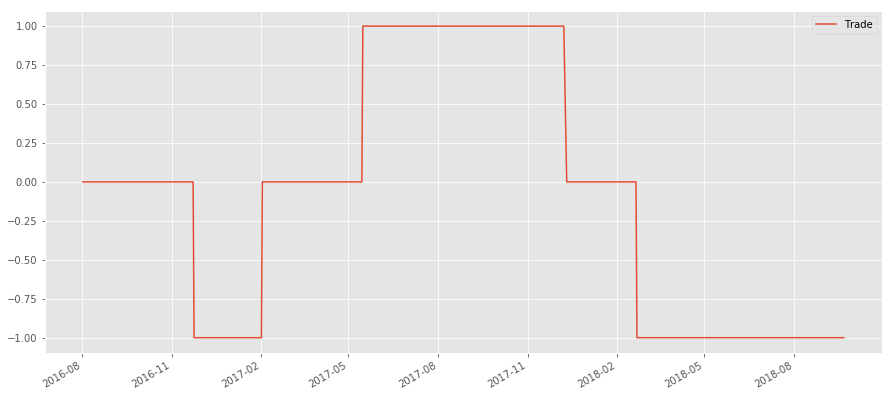

In [17]:
df[['Trade']].plot(figsize=(15, 7));

In [18]:
df['profit'] = df['Trade'] * df['ret']
print('Long spread {:.4f}, Short spread {:.4f}, Total profit {:.4f}'.format((np.exp(df.loc[df['Trade'] == 1, 'profit'].sum())-1)*100,
                                                                            (np.exp(df.loc[df['Trade'] == -1, 'profit'].sum())-1)*100,
                                                                            (np.exp(df['profit'].sum())-1)*100))
print('Avg Daily profit {:.4f}, STD Daily profit {:.4f}, Daily Sharpe {:.4f}'.format(df['profit'].mean()*100,
                                                                                     df['profit'].std()*100,
                                                                                     df['profit'].mean()/df['profit'].std()*100))

Long spread 14.2538, Short spread 16.4938, Total profit 33.0986
Avg Daily profit 0.0532, STD Daily profit 1.0452, Daily Sharpe 5.0941


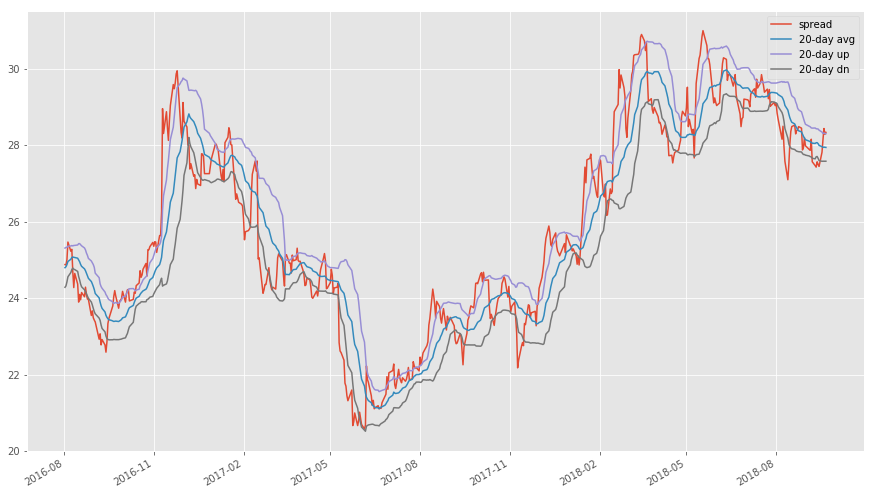

In [19]:
df[['spread', '20-day avg', '20-day up', '20-day dn']].plot(figsize=(15, 9));

In [20]:
df.head(10)

,slf,mfc,spread,20-day avg,20-day median,20-day std,20-day up,20-day dn,ret,Trade,Trade Dir,profit
2016-08-02,42.48,17.60,24.88,24.8000,24.880,0.513030,25.313030,24.286970,NaN,0,NoTrade,NaN
2016-08-03,42.79,17.92,24.87,24.8260,24.880,0.502084,25.328084,24.323916,-0.000402,0,NoTrade,-0.0
2016-08-04,41.96,16.95,25.01,24.8820,24.930,0.452171,25.334171,24.429829,0.005613,0,NoTrade,0.0
2016-08-05,42.68,17.21,25.47,24.9625,24.995,0.401076,25.363576,24.561424,0.018226,0,NoTrade,0.0
2016-08-08,42.63,17.40,25.23,25.0200,25.075,0.346638,25.366638,24.673362,-0.009468,0,NoTrade,-0.0
2016-08-09,42.75,17.47,25.28,25.0660,25.180,0.313946,25.379946,24.752054,0.001980,0,NoTrade,0.0
2016-08-10,42.02,17.33,24.69,25.0795,25.180,0.289564,25.369064,24.789936,-0.023615,0,NoTrade,-0.0
2016-08-11,41.63,17.35,24.28,25.0710,25.180,0.310736,25.381736,24.760264,-0.016745,0,NoTrade,-0.0
2016-08-12,41.66,17.01,24.65,25.0665,25.180,0.316382,25.382882,24.750118,0.015124,0,NoTrade,0.0
2016-08-15,41.57,17.20,24.37,25.0480,25.180,0.345918,25.393918,24.702082,-0.011424,0,NoTrade,-0.0
